# R syntactic sugar

SimpleITK in R attempts to make all the common R array operators and arithmetic work on images.

First we load SimpleITK and set up a viewer for notebooks, using the jet colourmap.

In [2]:
library(SimpleITK)

Dwidth <- grid::unit(10, "cm")
## version of show using a jet colourmap.
setMethod('show', '_p_itk__simple__Image',
          function(object)
          {
            jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"))
            a <- t(as.array(object))
            rg <- range(a)
            A <- (a-rg[1])/(rg[2]-rg[1])
            dd <- dim(a)
            sp <- object$GetSpacing()
            sz <- object$GetSize()
            worlddim <- sp*sz
            worlddim <- worlddim/worlddim[1]
            W <- Dwidth
            H <- Dwidth * worlddim[2]
            jc <- jet.colors(101)
            A <- jc[A*100 + 1]               
            dim(A) <- dim(a)
            grid::grid.raster(A,default.units="mm", width=W, height=H)

          }

          )
## Make a smaller plot size
options(repr.plot.height = 3, repr.plot.width=3)

[1] "show"

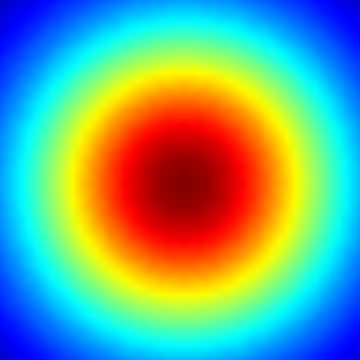

In [3]:
img = GaussianSource("sitkUInt8", size=c(64,64)) 
img

Here we note a problem with the swig bindings to the procedural interface - dispatching and defaults are not as nice as the python version. This means that we can't say
```r
GaborSource("sitkFloat32", size=c(64,64), frequency=.03)
```
because there are arguments missing before _frequency_ and swig can't generate default arguments from c++ code.

## Image slicing and indexing
Lets start by accessing a single pixel - note that indexing starts from 1:


In [22]:
img[25,25]

[1] 0.0489013

### Cropping

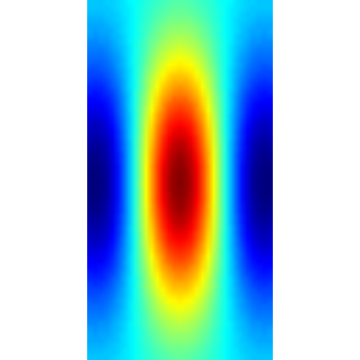

In [23]:
img[17:49,]

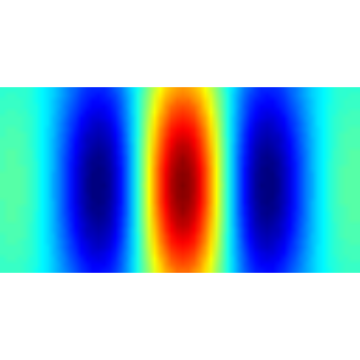

In [24]:
## Don't have the "from the end" slicing - negatives mean remove 

img[,16:(img$GetHeight() - 16)]


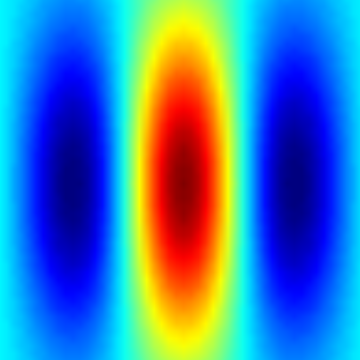

In [13]:
img = GaborSource("sitkFloat32", size=c(64,64), sigma=c(16, 16), mean=c(32,32), frequency=.03)
img

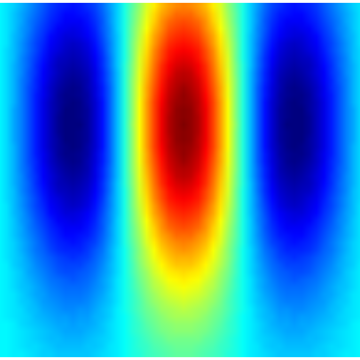

In [14]:
img[, -(1:16)]

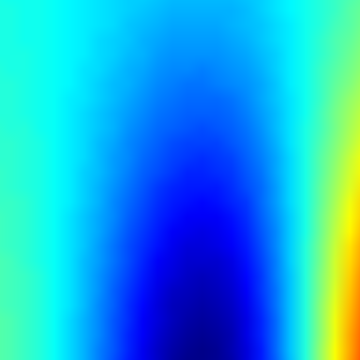

In [15]:
img[1:32, 1:32]

### Flipping

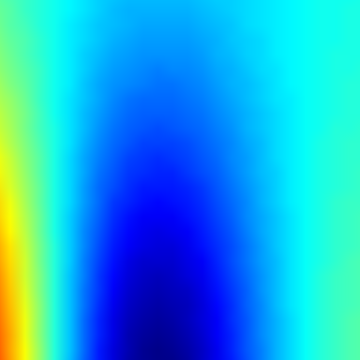

In [16]:
corner=img[1:32, 1:32]
corner[corner$GetWidth():1,]

### Tiling (using slicing)



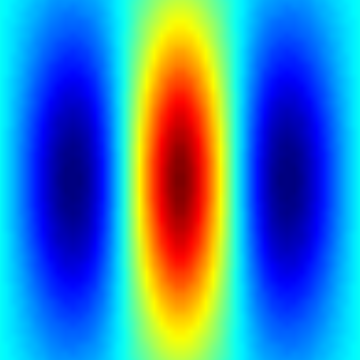

In [17]:
corner[c(1:corner$GetWidth(), corner$GetWidth():1), c(1:corner$GetHeight(), corner$GetHeight():1)]


### Tiling (with SimpleITK filters)

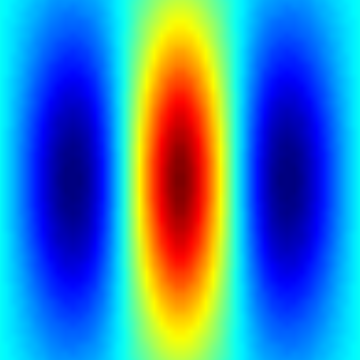

In [18]:
Tile(corner, corner[corner$GetWidth():1,],corner[,corner$GetHeight():1],corner[corner$GetWidth():1, corner$GetHeight():1], c(2,2))

### Slice extraction
Extracting a single slice of a 3D image is a natural extension:

In [19]:
img3d = GaborSource("sitkFloat32", size=rep(64,3), sigma=rep(16, 3), mean=rep(32,3), frequency=.05)

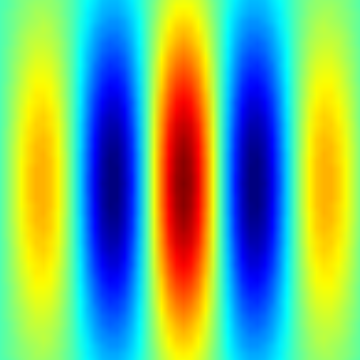

In [20]:
img3d[,,32]

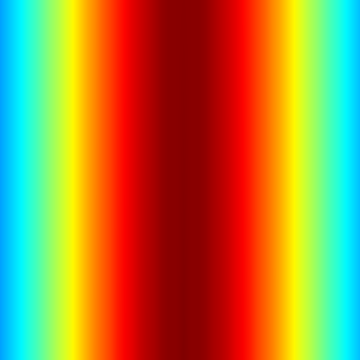

In [21]:
img3d[16,,]


### Subsampling
python notebook says supersampling - looks like subsampling to me.

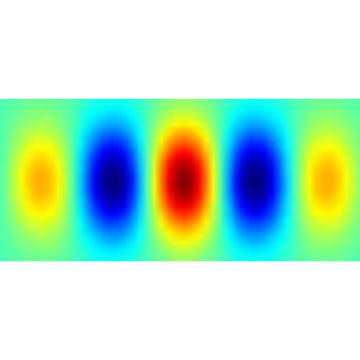

In [22]:
img3d[,seq(from=1, to=img3d$GetHeight(), by=3), 32]

## Mathematical Operators
Most array operations are overloaded for images - meaning that an ITK filter is used to perform the pixel-wise operations:

Loading required package: jsonlite

Attaching package: ‘jsonlite’

The following object is masked from ‘package:utils’:

    View



Fetching  cthead1.png 


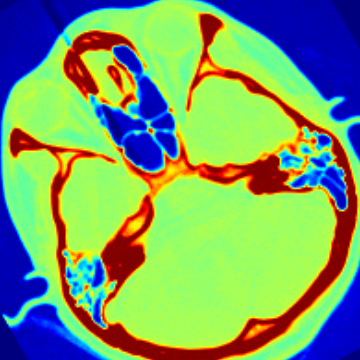

In [23]:
## source the functions for loading data
source("downloaddata.R")
cthead <- ReadImage(fetch_data("cthead1.png"))
img = Cast(cthead,"sitkFloat32")
img

In [25]:
img[150,150]

[1] 140

[1] 19600

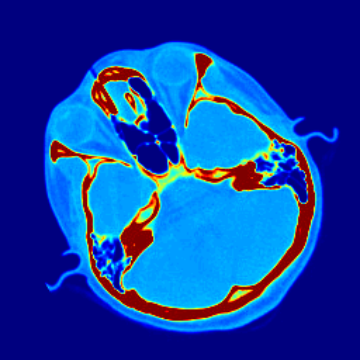

In [38]:
timg <- img**2
timg
timg[150,150]

In [33]:
aimg <- img + 100
aimg[150,150]

[1] 240

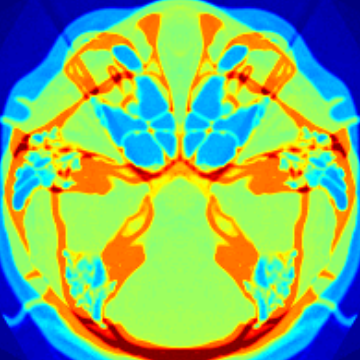

In [34]:
img + img[img$GetWidth():1, ]

## Logic and comparison operators

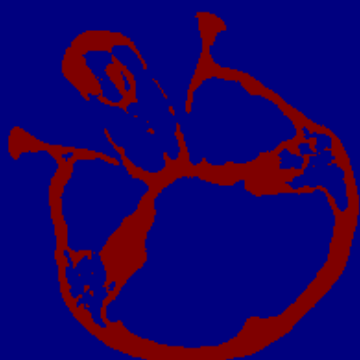

In [35]:
img > 150

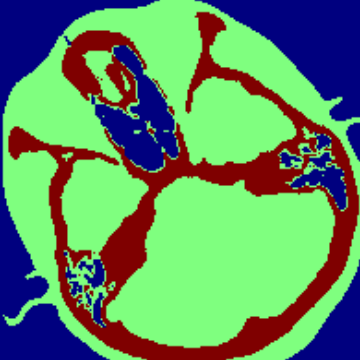

In [36]:
(img > 90) + (img > 150)

In [37]:
m <- (img > 90) != (img > 150)

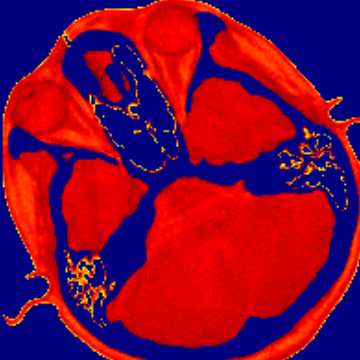

In [38]:
img * Cast(m, "sitkFloat32") 